# Analysis Pipeline For Calcium Transients Extracted from Imaging Data 

### Transiton state data (concatenated recordings)

Formozov, A., Chini, M. et al.
Calcium imaging and electrophysiology of hippocampal activity under anesthesia and natural sleep in mice (2021)

**Description: The notebook illustrates how to setup an analysis pipeline for reprocessed calcium imaging data, and how to analyze and visualize some basic features and correlations of calcium transients.**

*** To save notebook as pdf without code: ***
https://stackoverflow.com/questions/34818723/export-notebook-to-pdf-without-code?noredirect=1&lq=1

In [2]:
import numpy as np

import numpy.ma as ma

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import os

sns.set()
sns.set_style("whitegrid")

from scipy.signal import medfilt 

from scipy.stats import skew, kurtosis, zscore

from scipy import signal

from sklearn.linear_model import LinearRegression, TheilSenRegressor

### Download and compile OASIS and capipeline.py module (for colab only)

Johannes Friedrich, Pengcheng Zhou, Liam Paninski, Fast online deconvolution of calcium imaging data 
https://doi.org/10.1371/journal.pcbi.1005423

In [31]:
%%capture

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  !wget https://raw.githubusercontent.com/mchini/Yang_Chini_et_al/testTransition/notebooks/capipeline.py
  !git clone https://github.com/j-friedrich/OASIS.git
  !pwd
  %cd /content/OASIS/
  !pwd
  import warnings
  warnings.filterwarnings("ignore")
  !python setup.py build_ext --inplace
  %cd ..
  !pwd
  from sys import path
  path.append(r'/content/OASIS')
else:
  print('Not running on CoLab')

Not running on CoLab


### Import capipeline.py module with useful functions for the analysis

In [11]:
from capipeline import *

# Download data for reprocessing

## Download sample data from GIN (30 Mb)

In [8]:
# mimic path TS_C_ISO_8235 (transition state, concatenated, ISO, animal 8235)
full_path = "/data_colab/#8235_iso_minidataset/suite2p/plane0"
from pathlib import Path
path = Path('.' + full_path)
path.mkdir(parents=True, exist_ok=True)

In [4]:
# download data
%cd "./data_colab/#8235_iso_minidataset/suite2p/plane0"
download_path = "https://gin.g-node.org/SW_lab/Anesthesia_CA1/raw/master/data_colab/%238235_iso_minidataset/suite2p/plane0/"
files = ["iscell.npy","F.npy","Fneu.npy"]
for f in files:
    link = download_path + f
    !wget $link
    
%cd "../../../.."

# download meta_data
!wget "https://gin.g-node.org/SW_lab/Anesthesia_CA1/raw/master/data_colab/meta_recordings_8235.xlsx"

/media/andrey/My Passport/GITHUB_REPOS/Yang_Chini_et_al/notebooks/data_colab/#8235_iso_minidataset/suite2p/plane0
--2021-06-16 12:05:32--  https://gin.g-node.org/SW_lab/Anesthesia_CA1/raw/master/data_colab/%238235_iso_minidataset/suite2p/plane0/iscell.npy
Resolving gin.g-node.org (gin.g-node.org)... 141.84.41.219
Connecting to gin.g-node.org (gin.g-node.org)|141.84.41.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 928 [application/octet-stream]
Saving to: ‘iscell.npy.1’

iscell.npy.1        100%[===================>]     928  --.-KB/s    in 0s      

2021-06-16 12:05:34 (35,9 MB/s) - ‘iscell.npy.1’ saved [928/928]

--2021-06-16 12:05:34--  https://gin.g-node.org/SW_lab/Anesthesia_CA1/raw/master/data_colab/%238235_iso_minidataset/suite2p/plane0/F.npy
Resolving gin.g-node.org (gin.g-node.org)... 141.84.41.219
Connecting to gin.g-node.org (gin.g-node.org)|141.84.41.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14709528 (14M) [

### Setup path and choose animals for the analysis

In [9]:
animals =['TS_C_ISO_8235']

database_path = 'meta_recordings_8235.xlsx'

rec = get_recordings_for_animals(animals, database_path)

print("Recordings for the analysis: " + str(rec) )

Recordings for the analysis: [0, 1, 2, 3, 4, 5, 6, 7, 8]


### Plot raster plot for the first three recordings 

Total trace length: 73547
Recording length: 8604
Analysis periods: [1100, 6100]
Analysis period total frames:  5000
Total trace length: 73547
Recording length: 9000
Analysis periods: [0, 5000]
Analysis period total frames:  5000
Total trace length: 73547
Recording length: 8913
Analysis periods: [3200, 8200]
Analysis period total frames:  5000


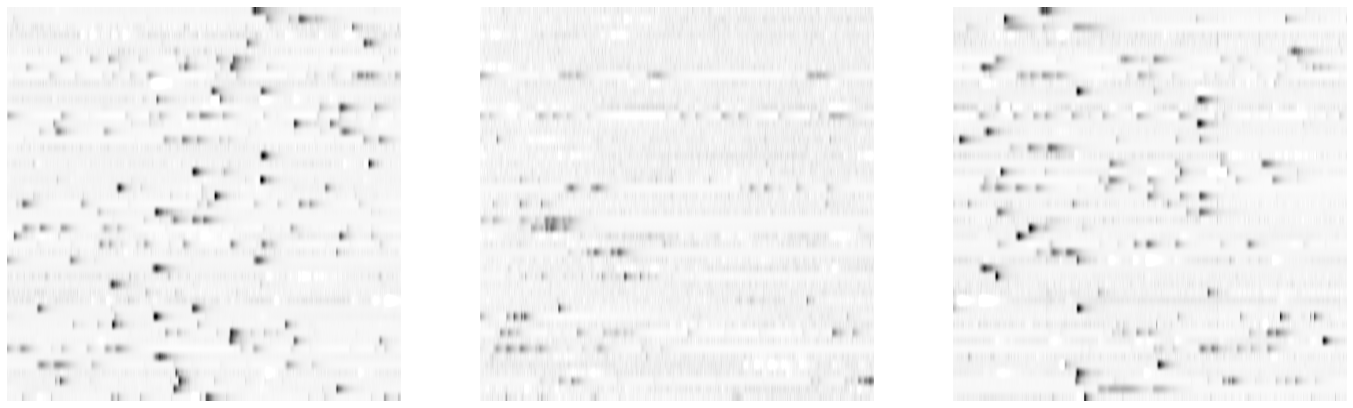

In [12]:
from capipeline import get_raster

nrec_to_plot = 3

starting_recording = rec[0]

fig, axes = plt.subplots(1, nrec_to_plot, figsize=(8*nrec_to_plot, 8), sharex=True)

for j in range(0,nrec_to_plot):
   
    raster = get_raster(starting_recording+j, 200, database_path, concatenation=True)
    
    axes[j].imshow(raster,extent=(0,7000,0,7000),cmap='Greys',vmin=0.25,vmax=1.0)
    
    axes[j].axis('off')

plt.show()

TS_C_ISO_8235 0 
Threshold for peak detection: 350
0 TS_C_ISO_8235 awake
Total trace length: 73547
Recording length: 8604
Analysis periods: [1100, 6100]
Analysis period total frames:  5000


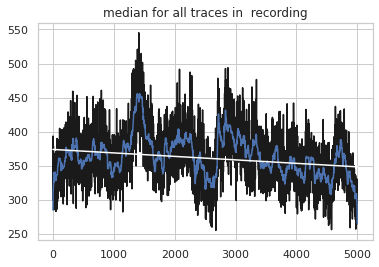

Median baseline: 276.57
Number of neurons accepted: 49
********************************
********************************
TS_C_ISO_8235 1 
Threshold for peak detection: 350
1 TS_C_ISO_8235 iso
Total trace length: 73547
Recording length: 9000
Analysis periods: [0, 5000]
Analysis period total frames:  5000


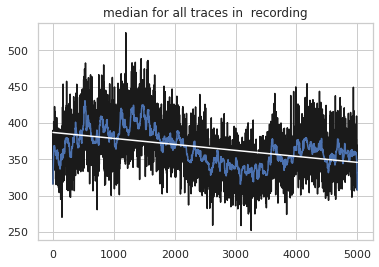

Median baseline: 286.52
Number of neurons accepted: 49
********************************
********************************
TS_C_ISO_8235 2 
Threshold for peak detection: 350
2 TS_C_ISO_8235 rec30
Total trace length: 73547
Recording length: 8913
Analysis periods: [3200, 8200]
Analysis period total frames:  5000


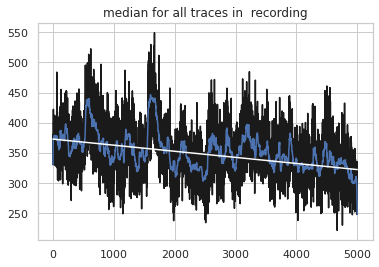

Median baseline: 268.65
Number of neurons accepted: 49
********************************
********************************
TS_C_ISO_8235 3 
Threshold for peak detection: 350
3 TS_C_ISO_8235 rec60
Total trace length: 73547
Recording length: 8924
Analysis periods: [0, 5000]
Analysis period total frames:  5000


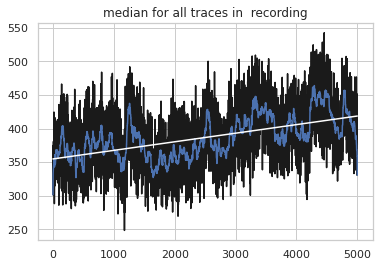

Median baseline: 239.41
Number of neurons accepted: 49
********************************
********************************
TS_C_ISO_8235 4 
Threshold for peak detection: 350
4 TS_C_ISO_8235 rec120
Total trace length: 73547
Recording length: 9773
Analysis periods: [0, 5000]
Analysis period total frames:  5000


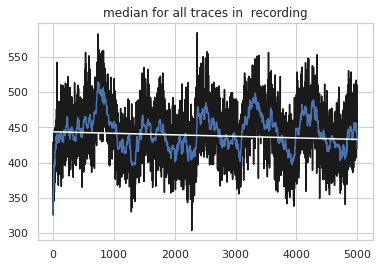

Median baseline: 356.35
Number of neurons accepted: 49
********************************
********************************
TS_C_ISO_8235 5 
Threshold for peak detection: 350
5 TS_C_ISO_8235 rec180
Total trace length: 73547
Recording length: 7623
Analysis periods: [0, 5000]
Analysis period total frames:  5000


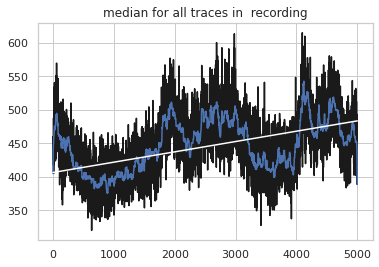

Median baseline: 288.49
Number of neurons accepted: 49
********************************
********************************
TS_C_ISO_8235 6 
Threshold for peak detection: 350
6 TS_C_ISO_8235 rec240
Total trace length: 73547
Recording length: 8215
Analysis periods: [0, 5000]
Analysis period total frames:  5000


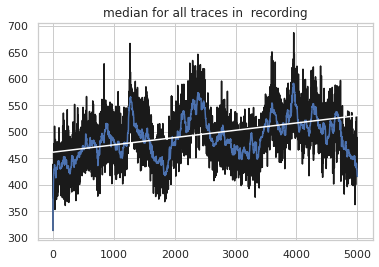

Median baseline: 335.37
Number of neurons accepted: 49
********************************
********************************
TS_C_ISO_8235 7 
Threshold for peak detection: 350
7 TS_C_ISO_8235 rec300
Total trace length: 73547
Recording length: 7075
Analysis periods: [0, 5000]
Analysis period total frames:  5000


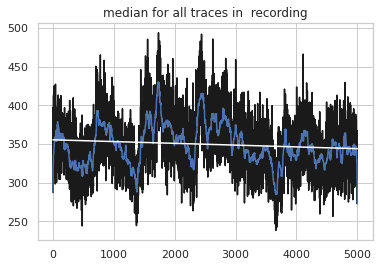

Median baseline: 250.70
Number of neurons accepted: 49
********************************
********************************
TS_C_ISO_8235 8 
Threshold for peak detection: 350
8 TS_C_ISO_8235 rec360
Total trace length: 73547
Recording length: 5419
Analysis periods: [0, 5000]
Analysis period total frames:  5000


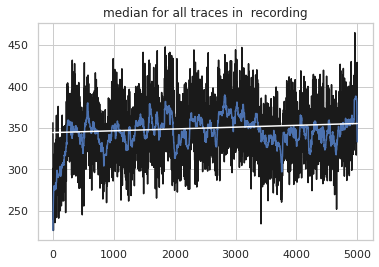

Median baseline: 249.12
Number of neurons accepted: 49
********************************
********************************


In [13]:
df_estimators = pd.DataFrame()

df_corrs =  pd.DataFrame()

for r in rec:
    
    animal = get_animal_from_recording(r, database_path)
    
    print(str(animal) + " " + str(r) + " ")

    if (animal=='TS_C_ISO_8235'): ### assign threshold
         threshold = 350  # for n-peaks detection
        
    print("Threshold for peak detection: " + str(threshold))
    df_e, df_c   = get_data_frame(r, database_path, threshold=threshold, baseline_correction=True,concatenation=True)

    df_estimators = pd.concat([df_estimators,df_e])
    df_corrs = pd.concat([df_corrs,df_c])

    print("********************************")
    print("********************************")

    
df_estimators['neuronID'] = df_estimators.index

### Store data frames for main features and correlations

In [11]:
df_estimators.to_pickle("./df_estimators_TS_C_ISO_8235_n_peaks_baseline.pkl") 
df_corrs.to_pickle("./df_corrs_TS_C_ISO_8235_n_peaks_baseline.pkl") 

### Load reprocessed data

In [12]:
df_estimators = pd.read_pickle("./df_estimators_TS_C_ISO_8235_n_peaks_baseline.pkl")
df_corrs = pd.read_pickle("./df_corrs_TS_C_ISO_8235_n_peaks_baseline.pkl")

### Check availible conditions

In [13]:
np.unique(df_estimators.condition)

array(['awake', 'iso', 'rec120', 'rec180', 'rec240', 'rec30', 'rec300',
       'rec360', 'rec60'], dtype=object)

### Get statistics on the features and correlations 

**Main features (df_estimators):**

- n_peaks
- width.median
- height.median
- decay time
- skewness
- integral
- baseline
- number of active neurons

**Correlations (df_corrs):**

- Pearson correlation of neurons 
- absolute Pearson correlation of neurons

In [14]:
df_estimators.describe()

recording    neuronID  n.accepted  length.frames  length.minutes  \
count  441.000000  441.000000       441.0          441.0      441.000000   
mean     4.000000   24.000000        49.0         5000.0        2.777778   
std      2.584921   14.158197         0.0            0.0        0.000000   
min      0.000000    0.000000        49.0         5000.0        2.777778   
25%      2.000000   12.000000        49.0         5000.0        2.777778   
50%      4.000000   24.000000        49.0         5000.0        2.777778   
75%      6.000000   36.000000        49.0         5000.0        2.777778   
max      8.000000   48.000000        49.0         5000.0        2.777778   

       n.accepted_and_rejected  traces.median  npil.median   trace.std  \
count                    441.0     441.000000   441.000000  441.000000   
mean                      50.0     690.647400   365.316528   55.474480   
std                        0.0     306.152588   117.501228   49.328030   
min                       50.0     169.321091   130.723618    8.153441   
25%                       50.0     476.945129   279.875031   22.913139   
50%                       50.0     627.783875   353.707520   37.034946   
75%                       50.0     850.111450   434.773560   68.101547   
max                       50.0    2412.975586   736.221069  335.842773   

         npil.std  ...  baseline.quantile.25  baseline.oasis     integral  \
count  441.000000  ...            441.000000      441.000000   441.000000   
mean    55.474480  ...            325.925866      214.766189   357.634386   
std     49.328030  ...            220.215061      195.160262   272.172996   
min      8.153441  ...            -31.840831        0.000000    -5.577714   
25%     22.913139  ...            162.464020       41.533961   180.409488   
50%     37.034946  ...            277.051285      175.211754   283.037275   
75%     68.101547  ...            449.625679      338.146510   441.933550   
max    335.842773  ...           1141.444122      818.879650  1832.183800   

       peak_detection_threshold  decay_isol  decay_no_isol     n_peaks  \
count                     441.0  441.000000     441.000000  441.000000   
mean                      350.0    0.588698       1.168621   40.097143   
std                         0.0    0.532170       0.401191   33.537988   
min                       350.0    0.004825       0.017085    0.000000   
25%                       350.0    0.470488       1.014987   11.160000   
50%                       350.0    0.606246       1.322949   30.960000   
75%                       350.0    0.684851       1.448731   64.440000   
max                       350.0   10.748980       1.635043  122.400000   

       n_peaks_per_recording  height.median  width.median  
count             441.000000     431.000000    431.000000  
mean              111.380952     791.042571     45.100790  
std                93.161078     567.536191    115.138158  
min                 0.000000     359.255310      5.364030  
25%                31.000000     456.574112     11.810966  
50%                86.000000     549.428497     16.785036  
75%               179.000000     835.737213     29.946128  
max               340.000000    4097.330933   1435.527247  

[8 rows x 39 columns]

In [15]:
df_corrs.describe()

recording    Tm0p7Ncorr  Tm0p7Ncorr.abs
count  21609.000000  21168.000000    21168.000000
mean       4.000000      0.005836        0.087920
std        2.582049      0.140130        0.109271
min        0.000000     -0.797169        0.000018
25%        2.000000     -0.065167        0.024396
50%        4.000000     -0.007418        0.056744
75%        6.000000      0.045968        0.107252
max        8.000000      0.953470        0.953470

### Get median value of the feature for a given animal

In [16]:
df_estimators[(df_estimators.animal=='TS_C_ISO_8235')].groupby('condition', as_index=False)['n_peaks'].median()

condition  n_peaks
0     awake    27.00
1       iso    31.32
2    rec120    35.28
3    rec180    39.96
4    rec240    38.88
5     rec30    27.00
6    rec300    20.88
7    rec360    23.76
8     rec60    27.36

In [17]:
df_corrs[(df_corrs['Tm0p7Ncorr.abs'] < 0.999)].groupby('condition', as_index=False)['Tm0p7Ncorr.abs'].median()

condition  Tm0p7Ncorr.abs
0     awake        0.062829
1       iso        0.038324
2    rec120        0.056996
3    rec180        0.062882
4    rec240        0.059642
5     rec30        0.066325
6    rec300        0.060192
7    rec360        0.055008
8     rec60        0.057508

### Violin plot for a given feature

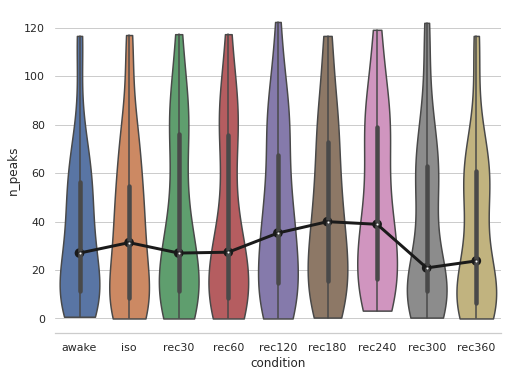

In [18]:
feature = 'n_peaks' # number of peaks per min
conditions = ["awake","iso","rec30","rec60","rec120","rec180","rec240","rec300","rec360"]

f, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
sns.despine(left=True)
#axes.set_ylim([0, 100.0])
sns.violinplot(x='condition', y=feature, data=df_estimators,ax=axes,order = conditions,scale='width',cut=0)
sns.pointplot(x='condition', y=feature, markers='o', scale=1.1, color='k',data=df_estimators.groupby('condition', as_index=False)[feature].median(), ax=axes,order=conditions)
plt.savefig("n_peaks.png")
plt.savefig("n_peaks.eps")

### Violin plot for correlations

Text(0, 0.5, 'Absolute Pearson Correlation')

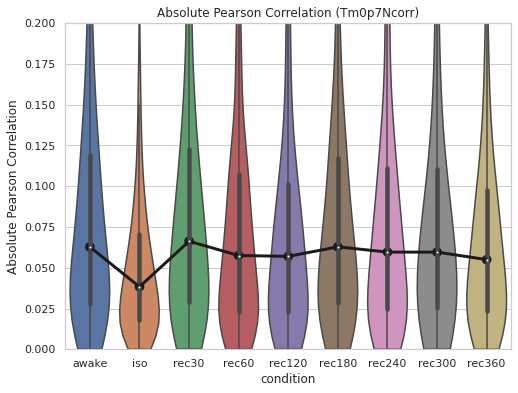

In [19]:
plt.rcParams['figure.figsize'] = [8, 6]

conditions = ["awake","iso","rec30","rec60","rec120","rec180","rec240","rec300","rec360"]

sns.violinplot(x='condition', y='Tm0p7Ncorr.abs',data=df_corrs[(df_corrs['Tm0p7Ncorr.abs'] < 0.9)],order=conditions,scale='width',cut=0)
sns.pointplot(x='condition', y='Tm0p7Ncorr.abs', markers='o', scale=1.1, color='k',data=df_corrs[(df_corrs['Tm0p7Ncorr.abs'] < 0.9)].groupby('condition', as_index=False)['Tm0p7Ncorr.abs'].median(),order=conditions)

plt.ylim([-0.00,0.2])
#plt.yscale('log')
#plt.savefig("correlations.png")
#plt.savefig("correlations.eps")
plt.title("Absolute Pearson Correlation (Tm0p7Ncorr)")
plt.ylabel("Absolute Pearson Correlation")


# Single-neuron level analysis

List of availible features:

'animal', 'recording', 'condition', 'neuronID', 'n.accepted', 'length.frames',
'length.minutes', 'n.accepted_and_rejected', 'traces.median', 'npil.median', 
'trace.std', 'npil.std', 'trace.mins', 'trace.maxs', 'trace.peak_to_peak', 
'npil.mins', 'npil.maxs', 'npil.peak_to_peak', 'trace.skewness', 'npil.skewness',
'Tm0p7N.skewness', 'Tm0p7N.median', 'Tm0p7N.std', 'trace.kurtosis', 'npil.kurtosis',
'npil.slope', 'npil.intercept', 'npil.residual', 'npil.slope_per_median', 'npil.slope_in_percent',
'npil.mstab.1000', 'baseline.quantile.25', 'baseline.oasis', 'integral', 'peak_detection_threshold',
'decay_isol', 'decay_no_isol', 'n_peaks', 'n_peaks_per_recording', 'height.median', 'width.median'


In [22]:
df_estimators['neuronID'] = df_estimators.index

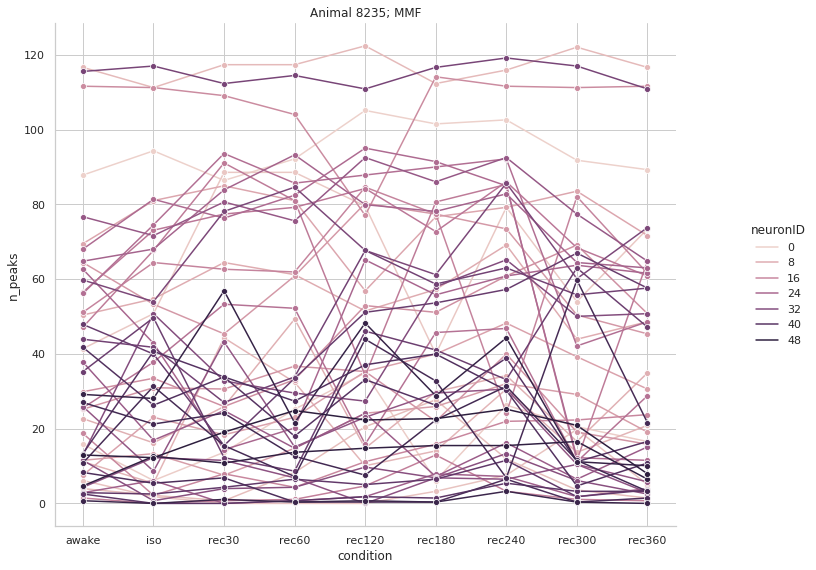

In [23]:
g=sns.relplot(x = 'condition',y = 'n_peaks', data = df_estimators[df_estimators.neuronID<50], marker='o',hue='neuronID',kind='line')
g.fig.set_size_inches(12,8)
plt.title("Animal 8235; MMF")
plt.savefig("single-neuron-level-analysis.png")
plt.savefig("single-neuron-level-analysis.eps")

### Conditioning (track neurons that active/non-active in awake condition)

In [24]:
neuron_ID_awake_active = df_estimators[(df_estimators.condition == 'awake')&(df_estimators.n_peaks > 10)].neuronID
neuron_ID_awake_non_active = df_estimators[(df_estimators.condition == 'awake')&(df_estimators.n_peaks < 10)].neuronID

In [25]:
df_estimators_non_active_in_awake = df_estimators.loc[df_estimators['neuronID'].isin(neuron_ID_awake_non_active)]
df_estimators_active_in_awake = df_estimators.loc[df_estimators['neuronID'].isin(neuron_ID_awake_active)]

Text(0.5, 1.0, 'Animal 8237; ISO (neurons active in awake condition, n_peaks > 10)')

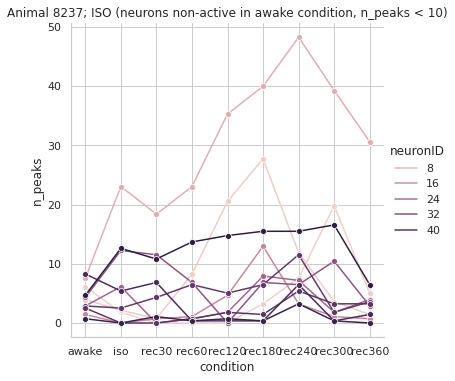

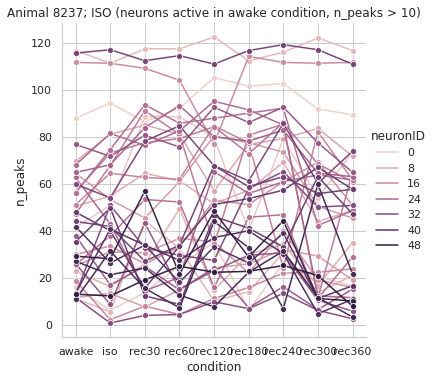

In [26]:
sns.relplot(x = 'condition',y = 'n_peaks', data = df_estimators_non_active_in_awake, marker='o',hue='neuronID',kind='line')
plt.title("Animal 8237; ISO (neurons non-active in awake condition, n_peaks < 10)")
sns.relplot(x = 'condition',y = 'n_peaks', data = df_estimators_active_in_awake, marker='o',hue='neuronID',kind='line')
plt.title("Animal 8237; ISO (neurons active in awake condition, n_peaks > 10)")

# Single-Neuron Level Analysis (interactive)

### Number of transients, hight of transients and decay time constant in different conditions

In [27]:
import plotly.express as px

x_axis = "condition"
y_axis = "n_peaks"
marker_color = "height.median"
marker_size = 'decay_no_isol'

fig = px.scatter(df_estimators[df_estimators.neuronID<50], x=x_axis, y=y_axis, color=marker_color,
                 size=marker_size,width=1000, height=600)
#fig.write_image("n_peaks_scatter_interactive.eps")
#fig.write_image("n_peaks_scatter_interactive.png")
fig.show()

In [28]:
import plotly.express as px

fig = px.scatter_3d(df_estimators[df_estimators.neuronID<50], x="condition", y="decay_no_isol", z="height.median",
              color="condition", size="n_peaks", size_max=18,
              symbol="condition", opacity=0.7,hover_data=['neuronID','trace.std'])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))